In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 60

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import glob
import os
import palettable

from joblib import parallel_backend

import sys
sys.path.append('../../Code')
from utils import save_adata, read_adata, pca_cytof
sys.path.append('../../Code/cNMF')
from cnmf import save_df_to_npz
from harmony import harmonize


import matplotlib.gridspec as gridspec


sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')
gcs = False

Autosaving every 60 seconds


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
adir = '../../../data/Emory/'
project_name = 'Emory_EVD_280K'
results_dir = '../../../results'


In [23]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [24]:
adata = read_adata(sample_file2, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [25]:
adata.obs['leiden_lab_group'].value_counts()

Mono        76189
Tc          69486
NK          44742
Th          35347
B           25088
NK/T        14349
Neut         6074
Doublet      3328
Basophil     2925
DC           2472
Name: leiden_lab_group, dtype: int64

In [26]:
ind = adata.obs['leiden_lab_group'].isin(['Mono', 'DC'])

In [27]:
adata_mono = adata[ind, :]

In [28]:
adata_mono

View of AnnData object with n_obs × n_vars = 78661 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix', 'leiden', 'leiden_lab', 'leiden_lab_group', 'is_control'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'collectionday_colors', 'is_control_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sid_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

In [29]:
pca_cytof(adata_mono)

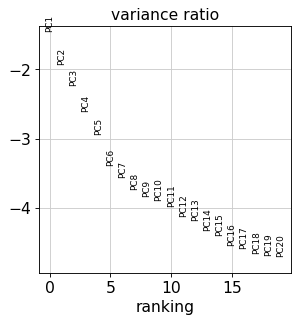

In [30]:
sc.pl.pca_variance_ratio(adata_mono, log=True)

In [31]:
adata_mono

AnnData object with n_obs × n_vars = 78661 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix', 'leiden', 'leiden_lab', 'leiden_lab_group', 'is_control'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'collectionday_colors', 'is_control_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sid_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

In [42]:
Z = harmonize(adata_mono.obsm['X_pca'], adata_mono.obs, batch_key = 'collectionday', theta=.1, random_state=14)
adata_mono.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [43]:
sc.pp.neighbors(adata_mono, n_neighbors=30, n_pcs=16, random_state=14, use_rep='X_harmony')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [44]:
sc.tl.umap(adata_mono, min_dist=0.1, spread=2.0, random_state=14)

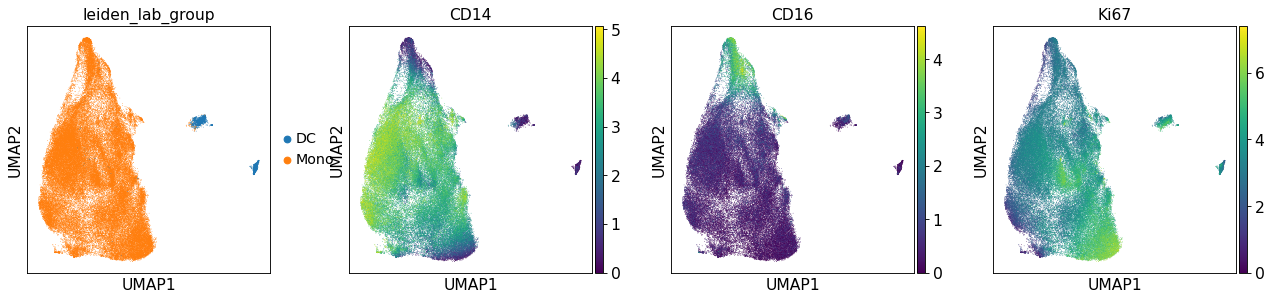

In [45]:
sc.pl.umap(adata_mono, color=['leiden_lab_group', 'CD14', 'CD16', 'Ki67'])

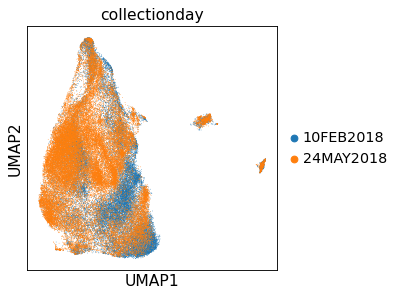

In [46]:
sc.pl.umap(adata_mono, color=['collectionday'])

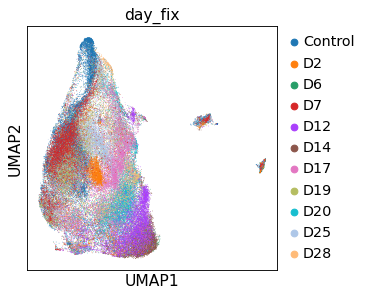

In [47]:
sc.pl.umap(adata_mono, color=['day_fix'])

In [38]:
sc.tl.leiden(adata_mono, resolution=.4, random_state=14)

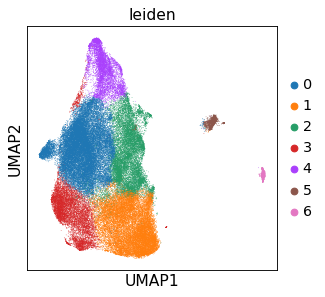

In [39]:
sc.pl.umap(adata_mono, color=['leiden'])

In [40]:
sc.tl.rank_genes_groups(adata_mono, 'leiden', method='wilcoxon')

In [41]:
pd.DataFrame(adata_mono.uns['rank_genes_groups']['names']).head(8)

,0,1,2,3,4,5,6
0,CD33,Ki67,IgM,CD11b,CD16,HLA-DR,CD123
1,CD14,STAT3,CD56,CD14,CD11c,IkBa,CD45RA
2,CD61,CD161,TBK1,CD61,HLA-DR,CD1c,HLA-DR
3,CD11c,P38,CD66,CD45,CD123,CD11c,CD4
4,CD11b,STAT1,STAT4,CD33,CD66,Ki67,CCR7
5,CD4,STAT4,Erk1_2,CD235a,BDCA3,4EBP1,IkBa
6,CD38,Erk1_2,STAT6,CD11c,CD45,CD19,CD38
7,CD45,S6,Fox_P3,CD27,CD45RA,CD123,CREB


In [61]:
labmap = {'0':'Mono 1', '1':'Mono 2', '2':'Mono 3','3':'Mono 4', '4':'Mono 5', '5':'cDC 1',
          '6':'pDC 1'}

In [62]:
adata_mono.obs['leiden_lab'] = adata_mono.obs['leiden'].replace(labmap)

In [63]:
adata_mono.obs['leiden_lab_group'] = adata_mono.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


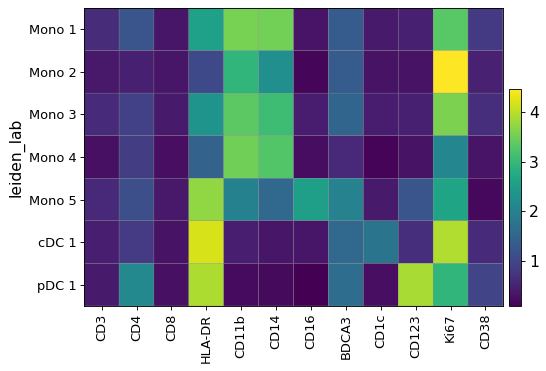

In [64]:
marker_genes = ['CD3', 'CD4', 'CD8', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'BDCA3', 'CD1c', 'CD123', 'Ki67', 'CD38']
gs = sc.pl.matrixplot(adata_mono,marker_genes, groupby='leiden_lab', figsize=(7,5))

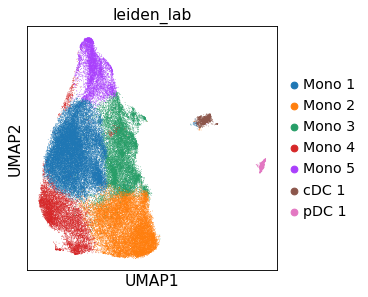

In [65]:
sc.pl.umap(adata_mono, color=['leiden_lab'])

In [66]:
adata_mono

AnnData object with n_obs × n_vars = 78661 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix', 'leiden', 'leiden_lab', 'leiden_lab_group', 'is_control'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'collectionday_colors', 'is_control_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sid_colors', 'day_fix_colors', 'leiden_colors', 'leiden_lab_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
monofn = '../../../data/Emory/Emory_EVD_280K.MyeloidOnly.Umap.Leiden.h5ad'

In [189]:
save_adata(adata_mono, monofn, gcs=False)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [3]:
adata_mono = read_adata(monofn, gcs=False)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [4]:
obs = adata_mono.obs[['sid', 'day_fix', 'leiden_lab_group', 'collectionday']].copy()
for c in ['CD14', 'CD16', 'HLA-DR', 'Ki67', 'CD38']:
    obs[c] = adata_mono.obs_vector(c)

In [5]:
obs_mono = obs.loc[obs['leiden_lab_group']=='Mono',:]

In [6]:
obs_mono['sample_merge'] = obs_mono['sid'].copy().astype(str)
ind = (obs_mono['day_fix']=='Control')
obs_mono.loc[ind, 'sample_merge'] = 'Control'
obs_mono['sample_merge'].unique()

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


array(['Control', 'EVD9', 'EVD2', 'EVD5', 'EVD15'], dtype=object)

In [7]:
obs_mono['day_fix_int'] = obs_mono['day_fix'].replace({'Control':'D0'}).apply(lambda x: x[1:]).astype(int)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
pd.crosstab([obs_mono['sid'], obs_mono['day_fix']], obs_mono['collectionday'])

collectionday  10FEB2018  24MAY2018
sid   day_fix                      
C145  Control       4996       5892
C928  Control       3628       4348
EVD2  D12              0       6303
      D19              0       8268
EVD5  D17              0       9191
      D25              0       4537
EVD9  D6            1484          0
      D14           7193          0
      D20           8669          0
      D28           3796          0
EVD15 D2               0       2671
      D7               0       5233

In [14]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [15]:
import matplotlib
from utils import draw_box, get_box_ind

[0, 6, 14, 20, 28]
[1, 1, 1, 1, 1, 0.1]


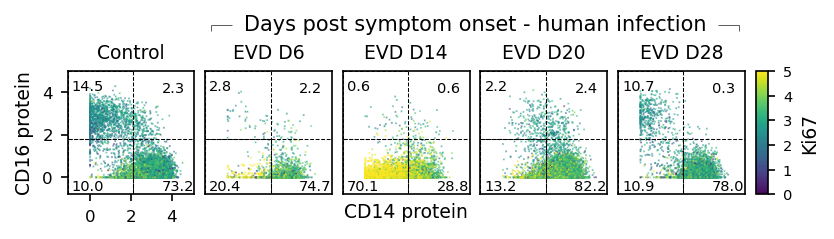

In [39]:
bw="scott"
clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 7

s = 'EVD9'
ind = obs_mono['sample_merge'].isin([s, 'Control']) & (obs_mono['collectionday'] == '10FEB2018')
subdata = obs_mono.loc[ind, :]
color_var='Ki67'
vmin=0
vmax=5

days = sorted(subdata['day_fix_int'].unique())
print(days)
ndays = len(days)
frac = 1


fig = plt.figure(figsize=(5.5,1.5), dpi=150)
width_ratios = ([1]*ndays)+[.1]
print(width_ratios)
gs = gridspec.GridSpec(2, ndays+1, figure=fig, left=.5/6.2, hspace=.5, wspace=.1,
                        bottom=.13, right=.93, top=.93, width_ratios=width_ratios,
                      height_ratios=[.15,.9])

axes = []
for i in range(ndays):
    axes.append(fig.add_subplot(gs[1,i],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=True, xlim=[-0.5,5.5], ylim=[-0.5,4.5]))
    
if color_var is not None:
    cbar_ax = fig.add_subplot(gs[1,ndays],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=True, xlim=[-0.5,5.5], ylim=[-0.5,4.5])


clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 10
dotsize = 1.
dpi = 0 
xlim=[-1.1,5.1]
ylim=[-0.8, 5.]
marker = matplotlib.markers.MarkerStyle(marker='X')
percent_lab_fontsize = 7


cd14_box = [2.1,2.1,xlim[1],xlim[1]], [ylim[0], 1.8, 1.8, ylim[0]]
cd16_box = [xlim[0],xlim[0],cd14_box[0][0], cd14_box[0][0]], [1.8, ylim[1],ylim[1], 1.8]
dneg_box2 = ([xlim[0], xlim[0], cd14_box[0][0], cd14_box[0][0]],
            [ylim[0], cd16_box[1][0], cd16_box[1][0], ylim[0]])

loc_pos = [(3.5, -.6), (-0.9, 4.1), (-.9, -.6), (3.5,4)]

for (i,day) in enumerate(days):
    ind = subdata['day_fix_int']==day      

    axes[i].set_title(day, pad=0, fontsize=10)
    samp = subdata.loc[ind,:].sample(frac=frac, replace=False)
    if color_var is None:
        axes[i].scatter(samp['CD14'], samp['CD16'], color='b',
                  s=dotsize, alpha=.7, marker=marker, edgecolor='None',
                  rasterized=True)
    else:
        cbarim = axes[i].scatter(samp['CD14'], samp['CD16'], c=samp[color_var],
                        s=dotsize, alpha=.7, marker=marker, edgecolor='None',
                        vmin=vmin, vmax=vmax, rasterized=True)
        
    num_cells = []
    num_pos_cells = []
    for (j,box) in enumerate([cd14_box, cd16_box, dneg_box2]):
        draw_box(box[0], box[1], ax=axes[i])
        ind_box = get_box_ind(box[0], box[1], subdata.loc[ind,'CD14'], subdata.loc[ind,'CD16'])
        num_cells.append(ind_box.sum())

    num_cells.append(ind.sum() - sum(num_cells))
    num_cells = np.array(num_cells)
    frac_cells = num_cells / num_cells.sum()
    percent_str = ['%.1f' % (x*100) for x in (frac_cells)]
    for j in range(len(loc_pos)):
        axes[i].text(loc_pos[j][0], loc_pos[j][1], percent_str[j], fontsize=percent_lab_fontsize)


    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

        
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].grid(False)
    
    if i == 0:
        axes[i].set_yticks([0, 2, 4])
        axes[i].set_xticks([0, 2, 4])
        axes[i].set_yticklabels([0, 2, 4], fontsize=8)
        axes[i].set_xticklabels([0, 2, 4], fontsize=8)
    else:
        axes[i].set_xticks([])
        axes[i].set_yticks([])

if color_var is not None:
    fig.colorbar(cbarim, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5], label=color_var)


axes[0].set_title('Control')
axes[1].set_title('EVD D6')
axes[2].set_title('EVD D14')
axes[3].set_title('EVD D20')
axes[4].set_title('EVD D28')

overlay_ax = fig.add_subplot(gs[0,1:-1],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=False, xlim=[0,1], ylim=[0,1])
overlay_ax.text(.5, .5, 'Days post symptom onset - human infection', va='center', ha='center', fontsize=10)    
overlay_ax.hlines(y=.5, xmin=0.01, xmax=.05, linewidth=.3)
overlay_ax.hlines(y=.5, xmin=.95, xmax=.99, linewidth=.3)
overlay_ax.vlines(x=.01, ymin=.2, ymax=.5, linewidth=.3)
overlay_ax.vlines(x=.99, ymin=.2, ymax=.5, linewidth=.3)

#plt.figtext(.53, -0.1 , 'CD14 protein', va='bottom', ha='center', fontsize=10)
#plt.figtext(-.01, 0.4 , 'CD16 protein', va='center', ha='left', rotation=90, fontsize=10)
axes[0].set_ylabel('CD16 protein')
axes[2].set_xlabel('CD14 protein')

figure_file = os.path.join(results_dir, "Human.EVD9.CD14vsCD16withKi67.Scatter.pdf")
fig.savefig(figure_file, dpi=300)

In [99]:
fig_width = 2.3
right = .87
left = .08
wspace = .1
ncols = 2
remX = (right-left) * fig_width
box_width = remX/(ncols + wspace)
right_abs = right*fig_width
left_abs = left*fig_width

fig_height = 4
top = .93
bottom = .1
hspace = .2
nrows = 3
remY = (top-bottom) * fig_height
box_height = remY/(nrows + hspace*(nrows-1))
top_abs = top*fig_height
bottom_abs = bottom*fig_height
hspace_abs = hspace*box_height

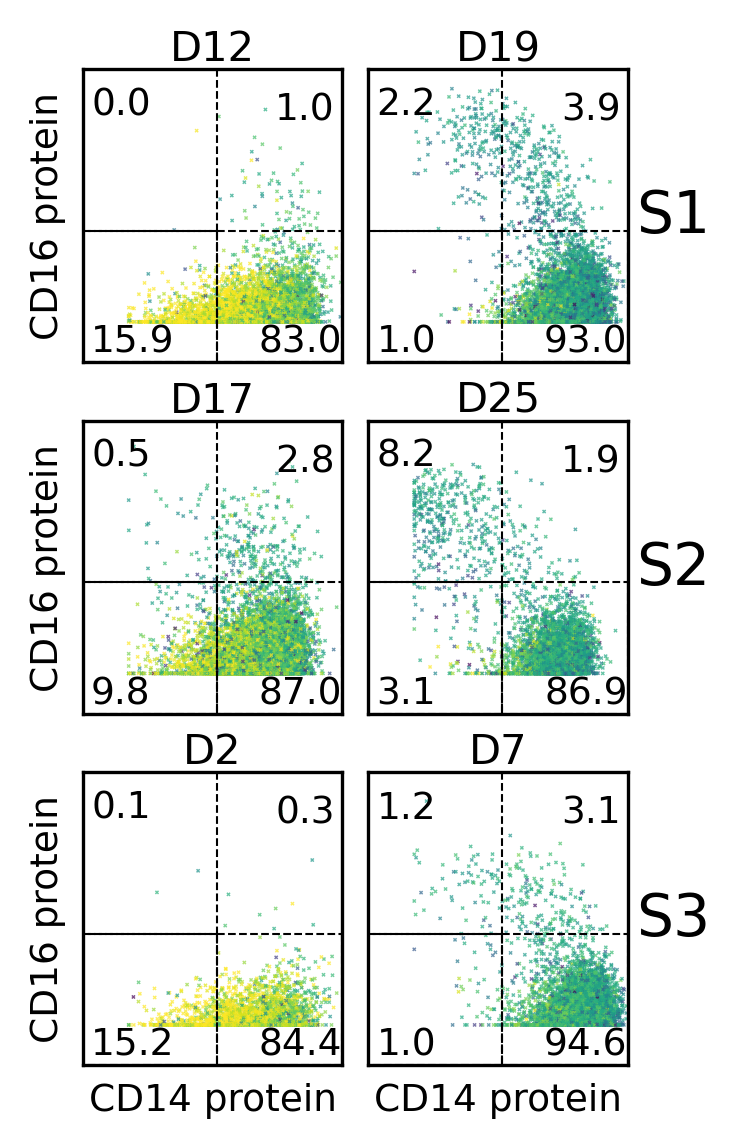

In [100]:
bw="scott"
clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 7

samples = ['EVD2', 'EVD5', 'EVD15']
color_var='Ki67'
vmin=0
vmax=5
ndays = 2
frac = 1

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
width_ratios = ([1]*ndays)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, left=left, hspace=hspace, wspace=wspace,
                        bottom=.1, right=right, top=.93, width_ratios=width_ratios,
                      height_ratios=[1, 1, 1])

axes = []

for i in range(len(samples)):
    day_axes = []
    for j in range(ndays):
        day_axes.append(fig.add_subplot(gs[i,j],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=True, xlim=[-0.5,5.5], ylim=[-0.5,4.5]))
    axes.append(day_axes)

clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 10
dotsize = 1.
dpi = 0 
xlim=[-1.1,5.1]
ylim=[-0.8, 5.]
marker = matplotlib.markers.MarkerStyle(marker='X')
percent_lab_fontsize = 9


cd14_box = [2.1,2.1,xlim[1],xlim[1]], [ylim[0], 1.8, 1.8, ylim[0]]
cd16_box = [xlim[0],xlim[0],cd14_box[0][0], cd14_box[0][0]], [1.8, ylim[1],ylim[1], 1.8]
dneg_box2 = ([xlim[0], xlim[0], cd14_box[0][0], cd14_box[0][0]],
            [ylim[0], cd16_box[1][0], cd16_box[1][0], ylim[0]])

loc_pos = [(3.1, -.6), (-0.9, 4.1), (-.9, -.6), (3.5,4)]

for (i,s) in enumerate(samples):
    ind = obs_mono['sample_merge'].isin([s]) & (obs_mono['collectionday'] == '24MAY2018')
    subdata = obs_mono.loc[ind, :]
    days = sorted(subdata['day_fix_int'].unique())
    
    for (j,day) in enumerate(days):
        ind = subdata['day_fix_int']==day
        if day == 0:
            axes[i][j].set_title('Control', pad=0, fontsize=10)
        else:
            axes[i][j].set_title('D%d' % day, pad=0, fontsize=10)

        samp = subdata.loc[ind,:].sample(frac=frac, replace=False)
        if color_var is None:
            axes[i][j].scatter(samp['CD14'], samp['CD16'], color='b',
                  s=dotsize, alpha=.7, marker=marker, edgecolor='None',
                  rasterized=True)
        else:
            cbarim = axes[i][j].scatter(samp['CD14'], samp['CD16'], c=samp[color_var],
                        s=dotsize, alpha=.7, marker=marker, edgecolor='None',
                        vmin=vmin, vmax=vmax, rasterized=True)
        
        num_cells = []
        num_pos_cells = []
        for box in [cd14_box, cd16_box, dneg_box2]:
            draw_box(box[0], box[1], ax=axes[i][j])
            ind_box = get_box_ind(box[0], box[1], subdata.loc[ind,'CD14'], subdata.loc[ind,'CD16'])
            num_cells.append(ind_box.sum())

        num_cells.append(ind.sum() - sum(num_cells))
        num_cells = np.array(num_cells)
        frac_cells = num_cells / num_cells.sum()
        percent_str = ['%.1f' % (x*100) for x in (frac_cells)]
        for k in range(len(loc_pos)):
            axes[i][j].text(loc_pos[k][0], loc_pos[k][1], percent_str[k], fontsize=percent_lab_fontsize)

        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')

        axes[i][j].set_xlim(xlim)
        axes[i][j].set_ylim(ylim)
        axes[i][j].grid(False)


for i in range(3):
    axes[i][0].set_ylabel('CD16 protein')

    
for i in range(2):
    axes[2][i].set_xlabel('CD14 protein')
        
ymid = (ylim[0]+ylim[1])/2
for (i,s) in enumerate(samples):
    axes[i][1].text(xlim[1]+.2, ymid, 'S%d' % (i+1), ha='left', va='center')

figure_file = os.path.join(results_dir, "Human.EVD2-5-14.CD14vsCD16withKi67.Scatter.pdf")
fig.savefig(figure_file, dpi=300)

In [114]:
wspace = .05
cbar_width_abs = .1
new_right = .77
new_left = .15

new_fig_width = (box_width + cbar_width_abs + .5*wspace*(box_width+cbar_width_abs)) / (new_right - new_left)

new_top = .9
new_bottom = .15
new_fig_height = box_height  / (new_top - new_bottom)

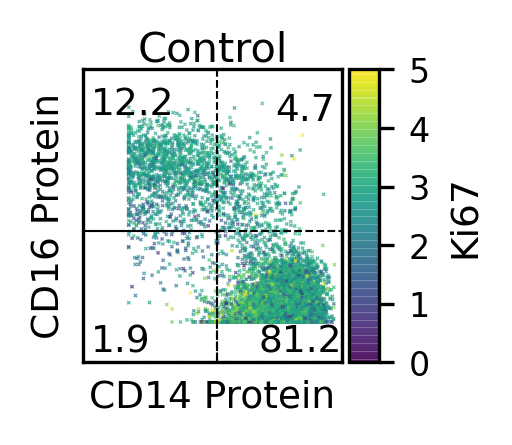

In [115]:
bw="scott"
clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 7

color_var='Ki67'
vmin=0
vmax=5
ndays = 1
frac = 1

fig = plt.figure(figsize=(new_fig_width,new_fig_height), dpi=300)
gs = gridspec.GridSpec(1,2, figure=fig, left=new_left, wspace=wspace,
                        bottom=new_bottom, right=new_right, top=new_top, width_ratios=[box_width,cbar_width_abs],
                      height_ratios=None)


day_ax = fig.add_subplot(gs[0],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=True, xlim=[-0.5,5.5], ylim=[-0.5,4.5])
    
cbar_ax = fig.add_subplot(gs[1],
                ylabel='', xlabel='',
                title='', xticks=[], yticks=[],
                frameon=True, xlim=[-0.5,5.5], ylim=[-0.5,4.5])
    
    

clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
cut=6
gridsize=100
n_levels = 10
dotsize = 1.
dpi = 0 
xlim=[-1.1,5.1]
ylim=[-0.8, 5.]
marker = matplotlib.markers.MarkerStyle(marker='X')
percent_lab_fontsize = 9


cd14_box = [2.1,2.1,xlim[1],xlim[1]], [ylim[0], 1.8, 1.8, ylim[0]]
cd16_box = [xlim[0],xlim[0],cd14_box[0][0], cd14_box[0][0]], [1.8, ylim[1],ylim[1], 1.8]
dneg_box2 = ([xlim[0], xlim[0], cd14_box[0][0], cd14_box[0][0]],
            [ylim[0], cd16_box[1][0], cd16_box[1][0], ylim[0]])

loc_pos = [(3.1, -.6), (-0.9, 4.1), (-.9, -.6), (3.5,4)]

ind = obs_mono['sample_merge'].isin(['Control']) & (obs_mono['collectionday'] == '24MAY2018')
subdata = obs_mono.loc[ind, :]
day_ax.set_title('Control', pad=0, fontsize=10)

samp = subdata.loc[ind,:].sample(frac=frac, replace=False)
cbarim = day_ax.scatter(samp['CD14'], samp['CD16'], c=samp[color_var],
                        s=dotsize, alpha=.7, marker=marker, edgecolor='None',
                        vmin=vmin, vmax=vmax, rasterized=True)

num_cells = []
num_pos_cells = []
for box in [cd14_box, cd16_box, dneg_box2]:
    draw_box(box[0], box[1], ax=day_ax)
    ind_box = get_box_ind(box[0], box[1], subdata.loc[ind,'CD14'], subdata.loc[ind,'CD16'])
    num_cells.append(ind_box.sum())

num_cells.append(ind.sum() - sum(num_cells))
num_cells = np.array(num_cells)
frac_cells = num_cells / num_cells.sum()
percent_str = ['%.1f' % (x*100) for x in (frac_cells)]
for k in range(len(loc_pos)):
    day_ax.text(loc_pos[k][0], loc_pos[k][1], percent_str[k], fontsize=percent_lab_fontsize)

    
day_ax.set_xlabel('CD14 Protein')
day_ax.set_ylabel('CD16 Protein')

day_ax.set_xlim(xlim)
day_ax.set_ylim(ylim)
day_ax.grid(False)

if color_var is not None:
    fig.colorbar(cbarim, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5], label=color_var)

cbar_ax.set_yticklabels([0, 1, 2, 3, 4, 5], fontsize=8)

figure_file = os.path.join(results_dir, "Human.Controls.CD14vsCD16withKi67.Scatter.pdf")
fig.savefig(figure_file, dpi=300)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

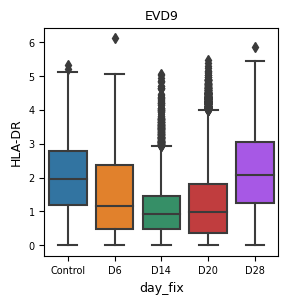

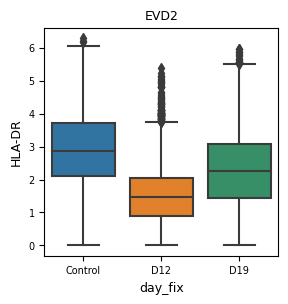

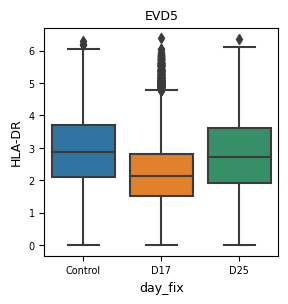

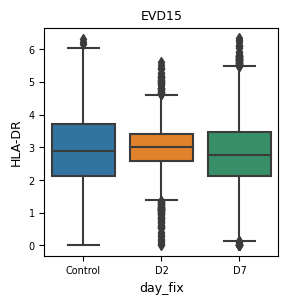

In [38]:
for sid in ['EVD9', 'EVD2', 'EVD5', 'EVD15']:
    cday = obs_mono.loc[obs_mono['sid']==sid, 'collectionday'].unique()[0]
    ind = obs_mono['sample_merge'].isin([sid, 'Control']) & (obs_mono['collectionday']==cday)
    subdat = obs_mono.loc[ind,:]
    subdat['day_fix'] = subdat['day_fix'].astype(str)
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=100)
    sns.boxplot(x='day_fix', y='HLA-DR', data=subdat, ax=ax)
    ax.set_title(sid)
    ax.grid(False)

In [36]:
3

3

In [ ]:
if color_var is not None:

    
    
